In [1]:
import requests
import os
from tqdm import tqdm

def download_file(link, file_name):
    response = requests.get(link, stream=True)
    if os.path.exists(file_name):
        print(f"The file {file_name} already exists, the file won't be downloaded")
        return
    total_size = int(response.headers.get('content-length', 0))
    
    with open(file_name, "wb") as f, tqdm(desc="Downloading file", total=total_size, unit='B', unit_scale=True, unit_divisor=1024,) as bar:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
                bar.update(len(chunk))  # Update progress bar by the chunk size
    
model_file_name = "ms2deepscore_model.pt"
neg_test_spectra_file_name = "neg_testing_spectra.mgf"
pos_test_spectra_file_name = "pos_testing_spectra.mgf"

download_file("https://zenodo.org/records/14290920/files/settings.json?download=1", "ms2deepscore_settings.json")
download_file("https://zenodo.org/records/14290920/files/ms2deepscore_model.pt?download=1", model_file_name)
download_file("https://zenodo.org/records/13934470/files/negative_testing_spectra.mgf?download=1", neg_test_spectra_file_name)
download_file("https://zenodo.org/records/13934470/files/positive_testing_spectra.mgf?download=1", pos_test_spectra_file_name)

The file ms2deepscore_settings.json already exists, the file won't be downloaded
The file ms2deepscore_model.pt already exists, the file won't be downloaded
The file neg_testing_spectra.mgf already exists, the file won't be downloaded
The file pos_testing_spectra.mgf already exists, the file won't be downloaded


In [2]:
from matchms.importing import load_from_mgf
from tqdm import tqdm
import os

pos_test = list(tqdm(load_from_mgf(pos_test_spectra_file_name)))
neg_test = list(tqdm(load_from_mgf(neg_test_spectra_file_name)))

24911it [00:12, 2039.96it/s]
7142it [00:03, 1791.68it/s]


### For one spectrum no fingerprint can be generated by RDKIT, this spectrum is removed. 
RDkit is not able to create a fingerprint for the smiles "O=C(N(CCN(CCN(C)[Na+])C(C)=O)CCN(CCN(CCN(C(C)=O)CCN(C)C(C)=O)C(C)=O)C(C)=O)C" therefore no tanimoto score can be calculated. So it can not be used for benchmarking the models.

In [3]:
pos_test_spectra = []
for spectrum in pos_test:
    if spectrum.get("inchikey")[:14] != "FTXGVGWYYREYSV":
        pos_test_spectra.append(spectrum)


### Calculate scores for test set

In [5]:
from ms2deepscore.benchmarking.CalculateScoresBetweenAllIonmodes import CalculateScoresBetweenAllIonmodes
scores_between_ionmodes = CalculateScoresBetweenAllIonmodes(model_file_name, pos_test_spectra, neg_test, fingerprint_type="daylight", n_bits_fingerprint=4096)

/lustre/BIF/nobackup/jonge094/ms2deepscore/ms2deepscore/ms2deepscore/models/load_model.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_settings = torch.load(filen

Calculating embeddings


24910it [00:48, 517.13it/s]
7142it [00:08, 799.53it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 924/924 [00:02<00:00, 386.09it/s]


Calculating tanimoto scores
Calculating embeddings


24910it [00:30, 820.36it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1830/1830 [00:04<00:00, 402.18it/s]


Calculating tanimoto scores
Calculating embeddings


7142it [00:08, 807.49it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 924/924 [00:02<00:00, 392.69it/s]


Calculating tanimoto scores


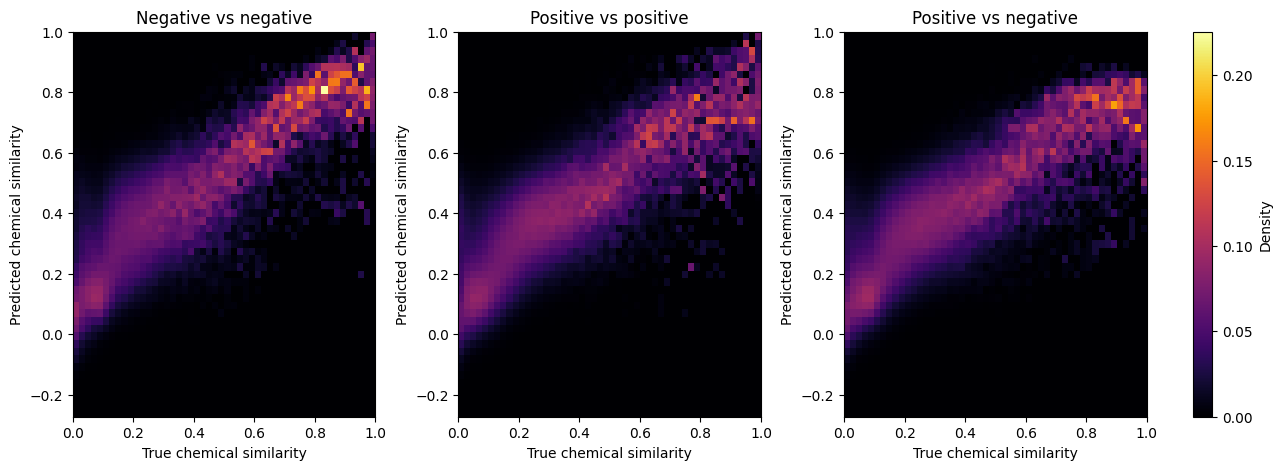

In [7]:
from ms2deepscore.benchmarking.plot_heatmaps import create_3_heatmaps
fig = create_3_heatmaps(scores_between_ionmodes, 50)
fig.savefig("./figures_benchmarking/heatmap.svg")

In [11]:
from scipy.stats import pearsonr
import numpy as np
def get_pearson_correlation(scores):
    predictions = scores.get_average_prediction_per_inchikey_pair().to_numpy().flatten()
    tanimoto_scores = scores.tanimoto_df.to_numpy().flatten()
    # the cases where there is only one spectrum against itself result in nan. these values need to be removed
    nan_value_indexes = np.where(np.isnan(predictions))
    predictions_without_nan = np.delete(predictions, nan_value_indexes)
    tanimoto_without_nan = np.delete(tanimoto_scores, nan_value_indexes)
    print(pearsonr(predictions_without_nan, tanimoto_without_nan))

In [12]:
get_pearson_correlation(scores_between_ionmodes.pos_vs_neg_scores)
get_pearson_correlation(scores_between_ionmodes.pos_vs_pos_scores)
get_pearson_correlation(scores_between_ionmodes.neg_vs_neg_scores)


PearsonRResult(statistic=0.46048130288130595, pvalue=0.0)
PearsonRResult(statistic=0.4519699260260151, pvalue=0.0)
PearsonRResult(statistic=0.4852323473124105, pvalue=0.0)


Selecting available inchikey pairs per bin: 50it [00:00, 94.50it/s] 
Selecting available inchikey pairs per bin: 50it [00:00, 203.42it/s]
Selecting available inchikey pairs per bin: 50it [00:00, 212.24it/s]


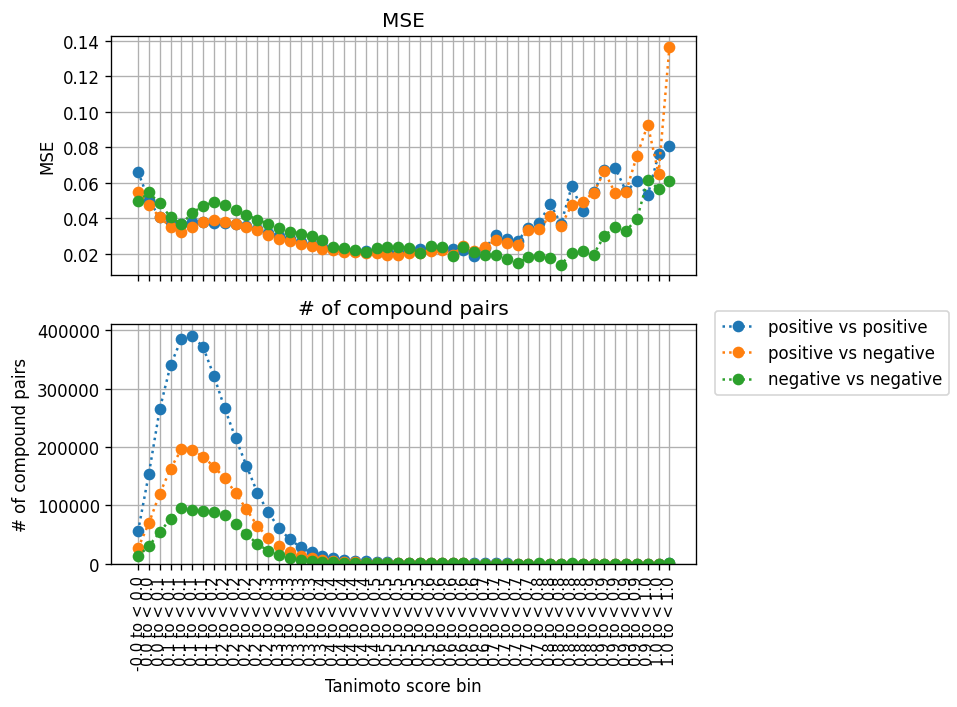

In [14]:
from ms2deepscore.benchmarking.plot_loss_per_bin import plot_loss_per_bin_multiple_benchmarks
plot_loss_per_bin_multiple_benchmarks(scores_between_ionmodes.list_of_predictions_and_tanimoto_scores(), 50)

Selecting available inchikey pairs per bin: 10it [00:00, 55.15it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 111.03it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 225.19it/s]


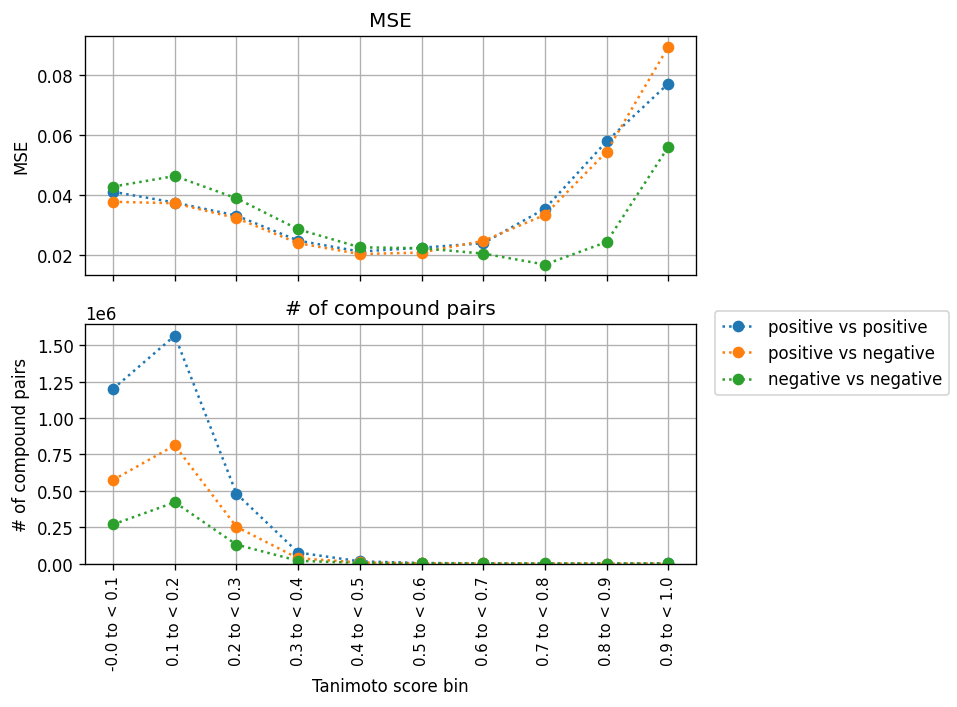

In [13]:
from ms2deepscore.benchmarking.plot_loss_per_bin import plot_loss_per_bin_multiple_benchmarks
plot_loss_per_bin_multiple_benchmarks(scores_between_ionmodes.list_of_predictions_and_tanimoto_scores(), 10, "MSE")

Selecting available inchikey pairs per bin: 20it [00:00, 75.35it/s]
Selecting available inchikey pairs per bin: 20it [00:00, 147.31it/s]
Selecting available inchikey pairs per bin: 20it [00:00, 301.73it/s]


Text(0.5, 1.0, 'average')

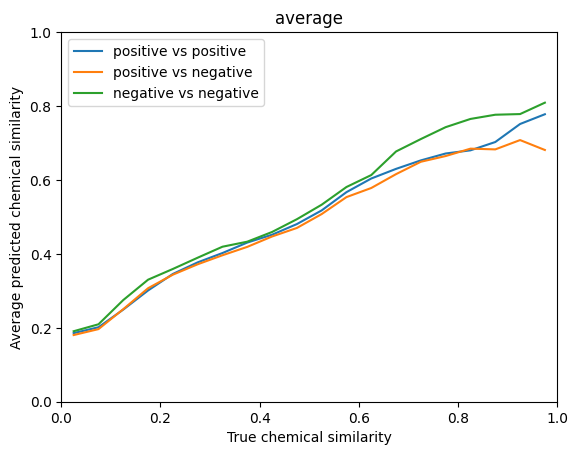

In [18]:
from ms2deepscore.benchmarking.plot_average_per_bin import plot_average_per_bin
from matplotlib import pyplot as plt

plot_average_per_bin(scores_between_ionmodes, 20)
plt.title("average")

Selecting available inchikey pairs per bin: 10it [00:00, 58.74it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 119.97it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 227.31it/s]


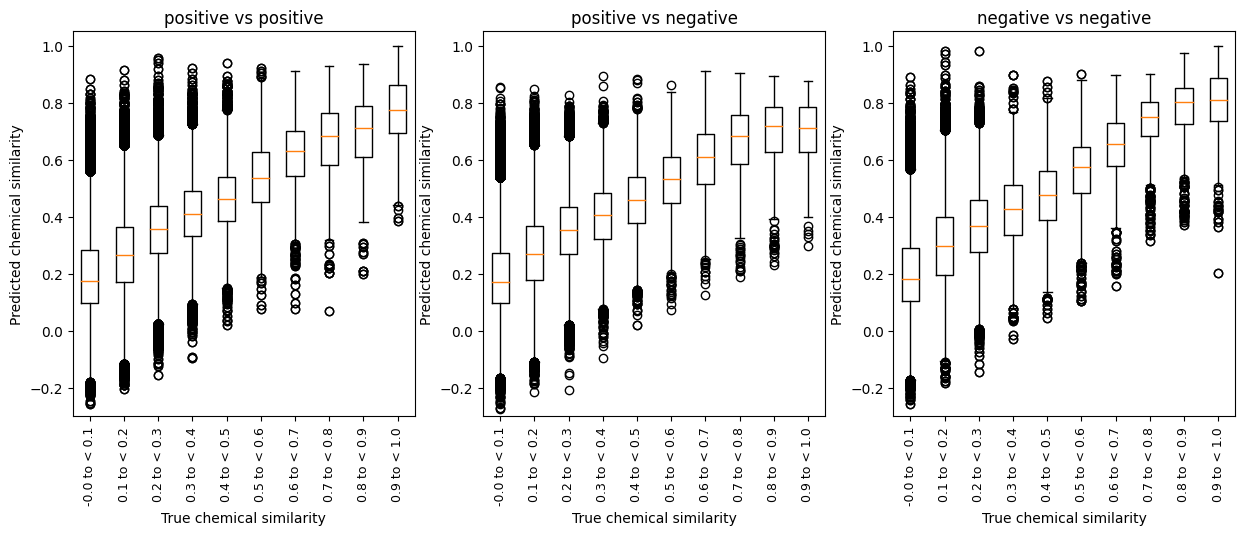

In [16]:
from matplotlib import pyplot as plt

from ms2deepscore.benchmarking.CalculateScoresBetweenAllIonmodes import CalculateScoresBetweenAllIonmodes
from ms2deepscore.utils import create_evenly_spaced_bins
import pandas as pd

def plot_boxplot_per_bin(scores_between_ionmodes: CalculateScoresBetweenAllIonmodes, nr_of_bins):
    bins = create_evenly_spaced_bins(nr_of_bins)
    bin_centers = [(bin_borders[0] + bin_borders[1])/2 for bin_borders in bins]
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))


    for i, predictions_and_tanimoto_scores in enumerate(scores_between_ionmodes.list_of_predictions_and_tanimoto_scores()):
        average_predictions = predictions_and_tanimoto_scores.get_average_prediction_per_inchikey_pair()
        predictions_per_bin = get_predictions_per_bin(predictions_and_tanimoto_scores, average_predictions, bins)
        axes[i].boxplot(predictions_per_bin, positions=np.arange(len(bins)))

        axes[i].set_xlabel("True chemical similarity")
        axes[i].set_ylabel("Predicted chemical similarity")
        axes[i].set_xticks(np.arange(len(bins)),
               [f"{a:.1f} to < {b:.1f}" for (a, b) in bins], fontsize=9, rotation='vertical')
        axes[i].set_title(predictions_and_tanimoto_scores.label)
        axes[i].set_ylim((-0.3,1.05))
    return fig

def get_predictions_per_bin(predictions_and_tanimoto_scores,
                            average_per_inchikey_pair: pd.DataFrame,
                            tanimoto_bins: np.ndarray):
    """Compute average loss per Tanimoto score bin

    Parameters
    ----------
    average_per_inchikey_pair
        Precalculated average (prediction or loss) per inchikey pair
    ref_score_bins
        Bins for the reference score to evaluate the performance of scores. in the form [(0.0, 0.1), (0.1, 0.2) ...]
    """
    average_predictions = average_per_inchikey_pair.to_numpy()

    sorted_bins = sorted(tanimoto_bins, key=lambda b: b[0])

    bins = [bin_pair[0] for bin_pair in sorted_bins]
    bins.append(sorted_bins[-1][1])

    digitized = np.digitize(predictions_and_tanimoto_scores.tanimoto_df, bins, right=True)
    predictions_per_bin = []
    for i, bin_edges in tqdm(enumerate(sorted_bins), desc="Selecting available inchikey pairs per bin"):
        row_idxs, col_idxs = np.where(digitized == i+ 1)
        predictions_in_this_bin = average_predictions[row_idxs, col_idxs]
        predictions_in_this_bin_not_nan = predictions_in_this_bin[~np.isnan(predictions_in_this_bin)]
        predictions_per_bin.append(predictions_in_this_bin_not_nan)
    return predictions_per_bin
fig = plot_boxplot_per_bin(scores_between_ionmodes, 10)
fig.savefig("./figures_benchmarking/boxplots.svg", bbox_inches="tight")
fig.show()

Selecting available inchikey pairs per bin: 20it [00:00, 70.50it/s]
Selecting available inchikey pairs per bin: 20it [00:00, 144.68it/s]
Selecting available inchikey pairs per bin: 20it [00:00, 289.82it/s]


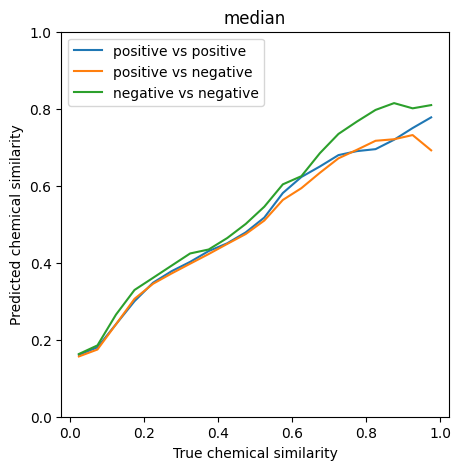

In [17]:
def plot_median_per_bin(scores_between_ionmodes: CalculateScoresBetweenAllIonmodes, nr_of_bins):
    bins = create_evenly_spaced_bins(nr_of_bins)
    bin_centers = [(bin_borders[0] + bin_borders[1])/2 for bin_borders in bins]
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))


    for i, predictions_and_tanimoto_scores in enumerate(scores_between_ionmodes.list_of_predictions_and_tanimoto_scores()):
        average_predictions = predictions_and_tanimoto_scores.get_average_prediction_per_inchikey_pair()
        predictions_per_bin = get_predictions_per_bin(predictions_and_tanimoto_scores, average_predictions, bins)
        medians = [np.median(array) for array in predictions_per_bin]
        ax.plot(bin_centers, medians, label=predictions_and_tanimoto_scores.label)

    ax.set_xlabel("True chemical similarity")
    ax.set_ylabel("Predicted chemical similarity")
    # ax.set_xticks(np.arange(len(bins)),
    #        [f"{a:.1f} to < {b:.1f}" for (a, b) in bins], fontsize=9, rotation='vertical')
    ax.set_ylim((0,1))
    plt.legend()
    plt.title("median")
    # axes[0].set_title(predictions_and_tanimoto_scores.label)
    return fig
fig = plot_median_per_bin(scores_between_ionmodes, 20)
fig.show()

In [ ]:
from ms2deepscore.benchmarking.plot_average_per_bin import plot_average_per_bin
plot_average_per_bin(scores_between_ionmodes, 50)